# Extract text chunks from XML with (sub)section metadata

This notebook focuses on **Acts** only.

Regulations will likely have a different structure and require different treatment.

**Deprecated in favor of notebook 3**

In [175]:
import textwrap


def nice_wrap(text, indent=0):
    # Just a utility function to improve printing to console
    return "\n".join(
        [
            "\n".join(
                textwrap.wrap(
                    line, 90, break_long_words=False, replace_whitespace=False, initial_indent=" " * indent
                )
            )
            for line in text.splitlines()
        ]
    )


def nice_print(text, indent=0):
    print(nice_wrap(text, indent))

def nice_print_dict(d, indent=0):
    for k, v in d.items():
        print(("\n" if not indent else "") + f"{' ' * indent}> {k}:")
        if isinstance(v, dict):
            nice_print_dict(v, indent=indent + 2)
        elif v is None:
            print(f"{' ' * indent}  <None>")
        else:
            nice_print(v, indent + 2)


In [176]:
import lxml.etree as ET
from markdownify import markdownify as md
import os
import re


def xslt_transform(xml_filename, xsl_filename):
    # https://stackoverflow.com/questions/16698935/how-to-transform-an-xml-file-using-xslt-in-python
    dom = ET.parse(xml_filename)
    xslt = ET.parse(xsl_filename)
    transform = ET.XSLT(xslt)
    newdom = transform(dom)
    return ET.tostring(newdom, pretty_print=True)

In [177]:
current_dir = os.getcwd()
root_dir = os.path.dirname(current_dir)
laws_dir = os.path.join(root_dir, 'laws-lois-xml')
xsl_filename = os.path.join(laws_dir, 'xslt', 'LIMS2HTML.xsl')
aca_en = os.path.join(laws_dir, 'eng', 'acts', 'A-0.6.xml')
aca_fr = os.path.join(laws_dir, 'fra', 'lois', 'A-0.6.xml')

aca_en_html = xslt_transform(aca_en, xsl_filename).decode('utf-8')
aca_fr_html = xslt_transform(aca_fr, xsl_filename).decode('utf-8')

with open(os.path.join(current_dir, 'aca-en.html'), 'w') as f:
    f.write(aca_en_html)
with open(os.path.join(current_dir, 'aca-fr.html'), 'w') as f:
    f.write(aca_fr_html)


## Extract sections and subsections from XML

In [178]:
# Extract Sections and subsections
# Doing this from the HTML didn't work. We have to go straight to the XML
import xml.etree.ElementTree as ET
from collections import defaultdict

# Parse the XML
tree = ET.parse(aca_en)
root = tree.getroot()

# Initialize a dictionary to store sections and their text
section_dict = defaultdict(dict)

# Iterate through the XML tree to extract sections and subsections
for section in root.findall('.//Section'):

    # Extract the section ID
    section_id = section.find('Label').text
    section_text = "\n".join([t.text for t in section.findall('.//*')[1:] if t.text]) if section.findall('.//*') else ""
    section_dict[section_id]["title"] = section.find('MarginalNote').text if section.find('MarginalNote') is not None else None
    section_dict[section_id]["text"] = section_text
    section_dict[section_id]["xml"] = ET.tostring(section, encoding='unicode')
    section_dict[section_id]["lims_id"] = section.attrib.get("{http://justice.gc.ca/lims}id", None)
    # Check if section has subsections
    if section.findall('.//Subsection'):
        # print("Found subsections")
        # If so, initialize a dictionary to store subsections and their text
        subsection_dict = {}
        # Iterate through the subsections
        for subsection in section.findall('.//Subsection'):
            # Extract the subsection ID
            subsection_id = subsection.find('Label').text
            # We want the subsection ID to be like <Section ID number>.<Subsection ID number> so we need to extract the numbers from the subsection ID
            subsection_id = re.search(r'\d+', subsection_id).group()
            subsection_id = f"{section_id}.{subsection_id}"
            # Extract the subsection text
            subsection_text = "\n".join([t.text for t in subsection.findall('.//*')[1:] if t.text]) if subsection.findall('.//*') else ""
            # Extract the title from the MarginalNote element, if any
            title = subsection.find('MarginalNote')
            if title is not None:
                title = title.text
            # Add the subsection to the subsection dictionary
            subsection_dict[subsection_id] = {
                "title": title,
                "text": subsection_text,
                "xml": ET.tostring(subsection, encoding='unicode'),
                "lims_id": subsection.attrib.get("{http://justice.gc.ca/lims}id", None)
            }
        # Add the subsection dictionary to the section dictionary
        section_dict[section_id]["subsections"] = subsection_dict


# Print the resulting dictionary
nice_print_dict(section_dict)


> 1:
  > title:
    Short title
  > text:
    1
    This Act may be cited as the
    Accessible Canada Act
  > xml:
    <Section xmlns:ns0="http://justice.gc.ca/lims" ns0:inforce-start-date="2019-07-11"
ns0:enacted-date="2019-06-21" ns0:lastAmendedDate="2019-07-11" ns0:fid="1153393"
ns0:id="1153393"><MarginalNote ns0:inforce-start-date="2019-07-11" ns0:enacted-
date="2019-06-21" ns0:fid="1153394" ns0:id="1153394">Short
title</MarginalNote><Label>1</Label><Text>This Act may be cited as the <XRefExternal
reference-type="act" link="A-0.6">Accessible Canada Act</XRefExternal>.</Text></Section>
  > lims_id:
    1153393

> 2:
  > title:
    Definitions
  > text:
    2
    The following definitions apply in this Act.
    Accessibility Commissioner
    Canadian Human Rights Act
    commissaire à l’accessibilité
    barrier
    obstacle
    broadcasting undertaking
    Broadcasting Act
    entreprise de radiodiffusion
    Canadian carrier
    Telecommunications Act
    entreprise canadienne
  

In [179]:
# How many sections?
print(len(section_dict), "sections")

# How many subsections?
print(sum([len(v.get("subsections", {})) for v in section_dict.values()]), "subsections")

# How many sections have subsections?
print(sum([1 for v in section_dict.values() if v.get("subsections", {}) != {}]), "sections have subsections")

# How many sections have no text?
print(sum([1 for v in section_dict.values() if v.get("text", "") == ""]), "sections have no text")

# How many sections have no title?
print(sum([1 for v in section_dict.values() if v.get("title", "") == ""]), "sections have no title")

# How many subsections have no text?
print(sum([1 for v in section_dict.values() for s in v.get("subsections", {}).values() if s.get("text", "") == ""]), "subsections have no text")

# How many subsections have no title?
print(sum([1 for v in section_dict.values() for s in v.get("subsections", {}).values() if s.get("title", "") == ""]), "subsections have no title")

209 sections
345 subsections
89 sections have subsections
0 sections have no text
0 sections have no title
0 subsections have no text
0 subsections have no title


In [180]:
# An example of a section with subsections
section_dict['7']

{'title': 'Application',
 'text': '7\n(1)\nThis Act applies to the following entities and persons:\n(a)\neach entity named or set out in any of Schedules I to V to the \nFinancial Administration Act\n(b)\neach \nCrown corporation\nFinancial Administration Act\n(c)\nevery portion of the federal public administration that is designated under subsection (3);\n(d)\nthe Canadian Forces;\n(e)\nany person, partnership or unincorporated organization that operates a work or carries on an undertaking or business that is within the legislative authority of Parliament, other than a work, undertaking or business of a local or private nature in Yukon, the Northwest Territories or Nunavut; and\n(f)\nany entity or person — including a trustee, executor, administrator, liquidator of the succession, guardian, curator or tutor — that acts in the name of, or for the benefit of, any entity or person in the operation of a work or carrying on of an undertaking or business that is within the legislative autho

Text(0.5, 1.0, 'Distribution of section lengths (chars)')

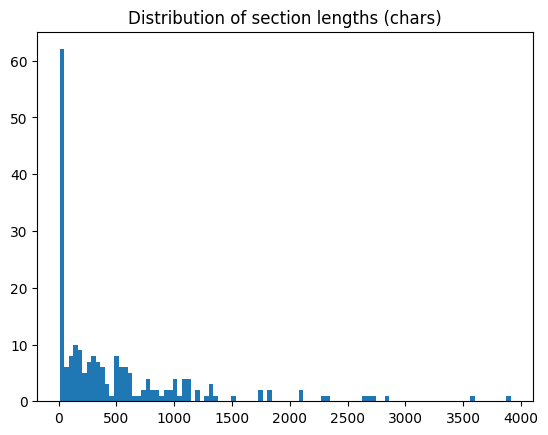

In [181]:
# Plot the distribution of section lengths
import matplotlib.pyplot as plt

section_lengths = [len(v.get("text", "")) for v in section_dict.values()]
# Plot histogram and set title
plt.hist(section_lengths, bins=100)
plt.title("Distribution of section lengths (chars)")

Text(0.5, 1.0, 'Distribution of subsection lengths (chars)')

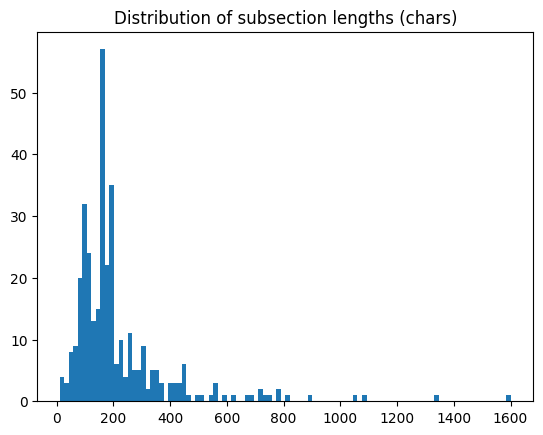

In [182]:
# And subsection lengths
subsection_lengths = [len(s.get("text", "")) for v in section_dict.values() for s in v.get("subsections", {}).values()]
plt.hist(subsection_lengths, bins=100)
plt.title("Distribution of subsection lengths (chars)")

In [183]:
# Find the longest subsections
sorted_subsections = sorted([(k, v.get("title", ""), v.get("text", "")) for v in section_dict.values() for k, v in v.get("subsections", {}).items()], key=lambda x: len(x[2]), reverse=True)

def print_sections(sections):
    for i, (id, title, text) in enumerate(sections[:5]):
        print(f"\n  ID: {id}")
        print(f"  Title: {title}")
        print(f"  Length: {len(text)}")
        print(f"  Text:")
        nice_print(text, indent=4)

print_sections(sorted_subsections[:2])


  ID: 73.2
  Title: Other powers
  Length: 1601
  Text:
    (2)
    The Accessibility Commissioner may, for that purpose,
    (a)
    open and examine any receptacle or package found in the place;
    (b)
    examine anything found in the place;
    (c)
    examine any record, report, electronic data or other document that is found in the
place and make copies of it or take extracts from it;
    (d)
    use or cause to be used any computer system at the place to examine any electronic
data referred to in paragraph (c);
    (e)
    reproduce any document from any electronic data referred to in paragraph (c), or cause
it to be reproduced, in the form of a printout or other output;
    (f)
    take the record, report or other document referred to in paragraph (c) or the printout
or other output referred to in paragraph (e) for examination or copying;
    (g)
    use or cause to be used any copying equipment at the place to make copies of any
document;
    (h)
    take photographs and mak

In [184]:
# Shortest subsections?
print_sections(sorted_subsections[-5:])


  ID: 142.6
  Title: Sections 
  Length: 29
  Text:
    126
    132
    (6)
    Sections
    126
    132

  ID: 140.10
  Title: Application — sections 
  Length: 26
  Text:
    85
    87
    (10)
    Sections
    85
    87

  ID: 139.2
  Title: Orders
  Length: 19
  Text:
    (2)
    Sections
    74
    76

  ID: 138.1
  Title: None
  Length: 15
  Text:
    Sections
    69
    71

  ID: 139.1
  Title: None
  Length: 11
  Text:
    Section
    73


In [185]:
# Shortest sections?
sorted_sections = sorted([(k, v.get("title", ""), v.get("text", "")) for k, v in section_dict.items()], key=lambda x: len(x[2]), reverse=True)
print_sections(sorted_sections[-5:])


  ID: 201
  Title: None
  Length: 12
  Text:
    [Amendments]

  ID: 202
  Title: None
  Length: 12
  Text:
    [Amendments]

  ID: 203
  Title: None
  Length: 12
  Text:
    [Amendments]

  ID: 204
  Title: None
  Length: 12
  Text:
    [Amendments]

  ID: 205
  Title: None
  Length: 12
  Text:
    [Amendments]


In [186]:
# We are still missing the preamble, which is composed of <Provision> inside <Preamble>

# Extract the provisions from the preamble
preamble = root.find('.//Preamble')
provisions = preamble.findall('.//Provision')

section_dict["0"] = {
    "title": "Preamble",
    "text": "\n".join([t.text for t in preamble.findall('.//*') if t.text]) if preamble.findall('.//*') else "",
    "subsections": {
        f"0.{i}": {
            "title": None,
            "text": " ".join([t.text for t in provision.findall('.//*') if t.text]) if provision.findall('.//*') else "",
        }
        for i, provision in enumerate(provisions)
    }
}

section_dict["0"]

{'title': 'Preamble',
 'text': 'Preamble\nWhereas the \nCanadian Charter of Rights and Freedoms\nWhereas the \nCanadian Human Rights Act\nWhereas a proactive and systemic approach for identifying, removing and preventing barriers to accessibility without delay complements the rights of persons with disabilities under the \nCanadian Human Rights Act\nWhereas Canada is a State Party to the United Nations Convention on the Rights of Persons with Disabilities and Canada has agreed to take appropriate measures respecting accessibility and to develop and monitor minimum accessibility standards;\nWhereas barriers to accessibility can impact all persons in Canada, in particular those with disabilities and their families, and can prevent persons with disabilities from achieving their full and equal participation in society;\nAnd whereas Parliament considers that it is essential to ensure the economic, social and civic participation of all persons in Canada, regardless of their disabilities, and

## Extract document-level metadata

In [187]:
# We should also extract some metadata like:
#  BillNumber, ConsolidatedNumber, ShortTitle, LongTitle (if they exist)
# Finally, we would like to extract from the Statute element the properties:
#  lims:lastAmendedDate, lims:current-date, lims:inforce-start-date, in-force

# Get document filename
xml_filename = aca_en

doc_obj = {
    "metadata": {
    "id": os.path.basename(xml_filename).replace(".xml", ""),
    "lang": os.path.basename(os.path.dirname(os.path.dirname(xml_filename))),
    "type": "act",
    "short_title": root.find('.//ShortTitle').text if root.find('.//ShortTitle') is not None else None,
    "long_title": root.find('.//LongTitle').text if root.find('.//LongTitle') is not None else None,
    "bill_number": root.find('.//BillNumber').text if root.find('.//BillNumber') is not None else None,
    "consolidated_number": root.find('.//ConsolidatedNumber').text if root.find('.//ConsolidatedNumber') is not None else None,
    "last_amended_date": root.attrib.get("{http://justice.gc.ca/lims}lastAmendedDate", None),
    "current_date": root.attrib.get("{http://justice.gc.ca/lims}current-date", None),
    "in_force_start_date": root.attrib.get("{http://justice.gc.ca/lims}inforce-start-date", None),
    },
    "sections": section_dict,
}

doc_obj

{'metadata': {'id': 'A-0.6',
  'lang': 'eng',
  'type': 'act',
  'short_title': 'Accessible Canada Act',
  'long_title': 'An Act to ensure a barrier-free Canada',
  'bill_number': 'C-81',
  'consolidated_number': 'A-0.6',
  'last_amended_date': '2023-04-27',
  'current_date': '2023-05-03',
  'in_force_start_date': '2019-06-21'},
 'sections': defaultdict(dict,
             {'1': {'title': 'Short title',
               'text': '1\nThis Act may be cited as the \nAccessible Canada Act',
               'xml': '<Section xmlns:ns0="http://justice.gc.ca/lims" ns0:inforce-start-date="2019-07-11" ns0:enacted-date="2019-06-21" ns0:lastAmendedDate="2019-07-11" ns0:fid="1153393" ns0:id="1153393"><MarginalNote ns0:inforce-start-date="2019-07-11" ns0:enacted-date="2019-06-21" ns0:fid="1153394" ns0:id="1153394">Short title</MarginalNote><Label>1</Label><Text>This Act may be cited as the <XRefExternal reference-type="act" link="A-0.6">Accessible Canada Act</XRefExternal>.</Text></Section>',
           

## Add XRefExternal links to sections and subsections
TODO: Use a similar method to in `extract-text-graph` notebook, but do this per-section and per-subsection. This will link individual chunks to related documents.

We can pull this right out of the XML, since we saved it in the section_dict.

In [188]:
# TODO

## Add XRefInternal links to sections and subsections

There is an easy way or a robust way to do this. For now, we will do the easy way. But see below for thoughts on why this is not optimal:

This is a relatively simple example of an internal reference to a subsection:
```xml
determined by regulations made under subsection <XRefInternal>45</XRefInternal>(1)
```

This is simple enough to parse. It should be subsection 45.1, which you can retrieve like:
```python
doc_obj["sections"]["45"]["subsections"]["45.1"]
```

However, even this requires parsing outside of the `<XRefInternal>` tag itself.

Sometimes the references are more complex. One of the worst examples:
```xml
in sections <XRefInternal>37</XRefInternal> to <XRefInternal>39</XRefInternal>
, <XRefInternal>76</XRefInternal>, <XRefInternal>82</XRefInternal>, <XRefInternal>
84</XRefInternal>, <XRefInternal>93</XRefInternal>, <XRefInternal>95</XRefInternal>
to <XRefInternal>103</XRefInternal> and <XRefInternal>110</XRefInternal> and
subsections <XRefInternal>140</XRefInternal>(5), (7) and (8) and the power to
delegate under this subsection and subsection (2)
```

**We may have to use LLM** to parse out the `XRefInternal` links into the correct format:
```python
{
    ...
    links_internal: ['45.1', '37', '38', '39', ... , '140.5', '140.7', '140.8', '42.1', '42.2']
}
```

Sometimes there are references to paragraphs, but we will **ignore those** since they will be caught under the Subsection link. e.g.
```xml
<Text>its policies, programs, practices and services in relation to the
identification and removal of barriers, and the prevention of new barriers,
in the areas referred to in paragraphs 5(a), (b), (f) and (g) and in the
area referred to in paragraph 5(c.1) as that paragraph applies in respect of
the areas referred to in those paragraphs; and</Text>
```

Like in the `extract-text-graph` notebook, a graph can be built between section nodes with in and out links.

In [189]:
# Minimum viable product: Only extract links to sections which have explicit XRefInternal.


{'title': 'Obligation',
 'text': '(1.1)\nThe Canadian Radio-television and Telecommunications Commission must make at least one regulation under subsection (1) within the period of two years that begins on the day on which this subsection comes into force.',
 'xml': '<Subsection xmlns:ns0="http://justice.gc.ca/lims" ns0:inforce-start-date="2019-07-11" ns0:enacted-date="2019-06-21" ns0:fid="1153694" ns0:id="1153694"><MarginalNote ns0:inforce-start-date="2019-07-11" ns0:enacted-date="2019-06-21" ns0:fid="1153695" ns0:id="1153695">Obligation</MarginalNote><Label>(1.1)</Label><Text>The Canadian Radio-television and Telecommunications Commission must make at least one regulation under subsection (1) within the period of two years that begins on the day on which this subsection comes into force.</Text></Subsection>',
 'lims_id': '1153694'}